# Stock Pattern Recognition

Technical analysis pattern detection on S&P 500 stocks.

## Patterns Implemented

1. **Head & Shoulders** - Reversal pattern with three peaks
2. **Double Top/Bottom** - Two similar peaks/troughs  
3. **Triangle** - Converging trendlines (ascending, descending, symmetric)
4. **Flag/Pennant** - Consolidation after sharp move
5. **Cup & Handle** - U-shaped bullish pattern

Analysis uses recent 3-year data and generates candlestick charts showing pattern formations.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import argrelextrema
from scipy.stats import linregress
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

DATA_DIR = Path("./sp500/sp500")
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data dir: {DATA_DIR}")
print(f"Output dir: {OUTPUT_DIR}")
print(f"Stock files: {len(list(DATA_DIR.glob('*.csv')))}")


Data dir: sp500\sp500
Output dir: outputs
Stock files: 503


## Setup and Configuration


In [2]:
def load_stock_data(ticker):
    """Load and clean stock data."""
    filepath = DATA_DIR / f"{ticker}.csv"
    if not filepath.exists():
        return None
    
    df = pd.read_csv(filepath)
    df = df.iloc[1:].reset_index(drop=True)  # Skip header row with ticker names
    
    df['Date'] = pd.to_datetime(df['Date'])
    for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df.dropna().sort_values('Date').reset_index(drop=True)

def get_available_tickers():
    """Get list of available ticker symbols."""
    return sorted([f.stem for f in DATA_DIR.glob('*.csv')])

# Test load
test_data = load_stock_data('AAPL')
print(f"Loaded AAPL: {len(test_data)} days, {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")


Loaded AAPL: 2515 days, 2015-01-02 to 2024-12-30


In [3]:
def find_peaks_troughs(prices, order=5):
    """Find local maxima and minima in price data."""
    peaks = argrelextrema(np.array(prices), np.greater, order=order)[0]
    troughs = argrelextrema(np.array(prices), np.less, order=order)[0]
    return peaks, troughs

def is_price_similar(price1, price2, tolerance=0.03):
    """Check if prices are similar within tolerance."""
    max_price = max(price1, price2)
    if max_price == 0:
        return True
    return abs(price1 - price2) / max_price < tolerance

# Test
test_peaks, test_troughs = find_peaks_troughs(test_data['Close'].values, order=10)
print(f"Peaks: {len(test_peaks)}, Troughs: {len(test_troughs)}")


Peaks: 61, Troughs: 66


## Head & Shoulders Detector

Bearish reversal: Three peaks (left shoulder, head, right shoulder) with neckline support.


In [4]:
def detect_head_and_shoulders(df, window=60, tolerance=0.05):
    """
    Detect Head & Shoulders pattern in stock data.
    
    Parameters:
    -----------
    df : DataFrame
        Stock data with Date and Close columns
    window : int
        Minimum days to look for pattern
    tolerance : float
        Price similarity tolerance (default 5%)
        
    Returns:
    --------
    list of dict
        Each dict contains pattern details and validation status
    """
    prices = df['Close'].values
    dates = df['Date'].values
    peaks, troughs = find_peaks_troughs(prices, order=10)
    
    patterns = []
    
    # Need at least 3 peaks and 2 troughs
    if len(peaks) < 3 or len(troughs) < 2:
        return patterns
    
    # Search for head and shoulders pattern
    for i in range(len(peaks) - 2):
        left_shoulder_idx = peaks[i]
        head_idx = peaks[i + 1]
        right_shoulder_idx = peaks[i + 2]
        
        # Get prices
        left_shoulder = prices[left_shoulder_idx]
        head = prices[head_idx]
        right_shoulder = prices[right_shoulder_idx]
        
        # Find troughs between peaks
        troughs_between = troughs[(troughs > left_shoulder_idx) & (troughs < right_shoulder_idx)]
        
        if len(troughs_between) < 2:
            continue
            
        # Get the two main troughs
        left_trough_idx = troughs_between[troughs_between < head_idx][-1] if len(troughs_between[troughs_between < head_idx]) > 0 else None
        right_trough_idx = troughs_between[troughs_between > head_idx][0] if len(troughs_between[troughs_between > head_idx]) > 0 else None
        
        if left_trough_idx is None or right_trough_idx is None:
            continue
            
        left_trough = prices[left_trough_idx]
        right_trough = prices[right_trough_idx]
        
        # Validation criteria
        valid = True
        reasons = []
        
        # 1. Head must be higher than both shoulders
        if head <= left_shoulder or head <= right_shoulder:
            valid = False
            reasons.append("Head not higher than shoulders")
        
        # 2. Shoulders should be at similar heights
        if not is_price_similar(left_shoulder, right_shoulder, tolerance):
            valid = False
            reasons.append(f"Shoulders not similar: {abs(left_shoulder-right_shoulder)/max(left_shoulder,right_shoulder)*100:.1f}% difference")
        
        # 3. Head should be notably higher than shoulders (at least 5%)
        min_shoulder = min(left_shoulder, right_shoulder)
        if (head - min_shoulder) / min_shoulder < 0.05:
            valid = False
            reasons.append("Head not significantly higher than shoulders")
        
        # 4. Neckline should be relatively horizontal
        neckline_slope = abs(right_trough - left_trough) / left_trough
        if neckline_slope > tolerance:
            valid = False
            reasons.append(f"Neckline too steep: {neckline_slope*100:.1f}%")
        
        # 5. Pattern should span reasonable time
        pattern_duration = right_shoulder_idx - left_shoulder_idx
        if pattern_duration < window:
            valid = False
            reasons.append(f"Pattern too short: {pattern_duration} days")
        
        pattern = {
            'type': 'Head & Shoulders',
            'valid': valid,
            'confidence': 1.0 if valid else 0.5,
            'start_date': str(dates[left_shoulder_idx]),
            'end_date': str(dates[right_shoulder_idx]),
            'duration_days': int(pattern_duration),
            'left_shoulder': {'date': str(dates[left_shoulder_idx]), 'price': float(left_shoulder), 'index': int(left_shoulder_idx)},
            'head': {'date': str(dates[head_idx]), 'price': float(head), 'index': int(head_idx)},
            'right_shoulder': {'date': str(dates[right_shoulder_idx]), 'price': float(right_shoulder), 'index': int(right_shoulder_idx)},
            'left_trough': {'date': str(dates[left_trough_idx]), 'price': float(left_trough), 'index': int(left_trough_idx)},
            'right_trough': {'date': str(dates[right_trough_idx]), 'price': float(right_trough), 'index': int(right_trough_idx)},
            'neckline_level': float((left_trough + right_trough) / 2),
            'validation_reasons': reasons if not valid else ['All criteria met']
        }
        
        patterns.append(pattern)
    
    return patterns


## Double Top/Bottom Detector

Double Top (M-shape): Bearish reversal with two similar peaks.
Double Bottom (W-shape): Bullish reversal with two similar troughs.


In [5]:
def detect_double_top_bottom(df, window=30, tolerance=0.03):
    """
    Detect Double Top and Double Bottom patterns.
    
    Parameters:
    -----------
    df : DataFrame
        Stock data with Date and Close columns
    window : int
        Minimum days between tops/bottoms
    tolerance : float
        Price similarity tolerance (default 3%)
        
    Returns:
    --------
    list of dict
        Each dict contains pattern details and validation status
    """
    prices = df['Close'].values
    dates = df['Date'].values
    peaks, troughs = find_peaks_troughs(prices, order=10)
    
    patterns = []
    
    # Detect Double Top
    for i in range(len(peaks) - 1):
        for j in range(i + 1, len(peaks)):
            first_peak_idx = peaks[i]
            second_peak_idx = peaks[j]
            
            first_peak = prices[first_peak_idx]
            second_peak = prices[second_peak_idx]
            
            # Find trough between peaks
            troughs_between = troughs[(troughs > first_peak_idx) & (troughs < second_peak_idx)]
            
            if len(troughs_between) == 0:
                continue
            
            middle_trough_idx = troughs_between[np.argmin(prices[troughs_between])]
            middle_trough = prices[middle_trough_idx]
            
            # Validation criteria
            valid = True
            reasons = []
            
            # 1. Peaks should be at similar levels
            if not is_price_similar(first_peak, second_peak, tolerance):
                valid = False
                reasons.append(f"Peaks not similar: {abs(first_peak-second_peak)/max(first_peak,second_peak)*100:.1f}% difference")
            
            # 2. Middle trough should be significantly lower (at least 5%)
            avg_peak = (first_peak + second_peak) / 2
            if (avg_peak - middle_trough) / avg_peak < 0.05:
                valid = False
                reasons.append("Middle trough not significantly lower")
            
            # 3. Pattern duration check
            pattern_duration = second_peak_idx - first_peak_idx
            if pattern_duration < window:
                valid = False
                reasons.append(f"Pattern too short: {pattern_duration} days")
            
            # 4. Peaks shouldn't be too far apart
            if pattern_duration > 250:  # ~1 year
                valid = False
                reasons.append(f"Pattern too long: {pattern_duration} days")
            
            pattern = {
                'type': 'Double Top',
                'valid': valid,
                'confidence': 1.0 if valid else 0.5,
                'start_date': str(dates[first_peak_idx]),
                'end_date': str(dates[second_peak_idx]),
                'duration_days': int(pattern_duration),
                'first_peak': {'date': str(dates[first_peak_idx]), 'price': float(first_peak), 'index': int(first_peak_idx)},
                'second_peak': {'date': str(dates[second_peak_idx]), 'price': float(second_peak), 'index': int(second_peak_idx)},
                'middle_trough': {'date': str(dates[middle_trough_idx]), 'price': float(middle_trough), 'index': int(middle_trough_idx)},
                'support_level': float(middle_trough),
                'validation_reasons': reasons if not valid else ['All criteria met']
            }
            
            patterns.append(pattern)
            break  # Only take the nearest valid second peak
    
    # Detect Double Bottom
    for i in range(len(troughs) - 1):
        for j in range(i + 1, len(troughs)):
            first_trough_idx = troughs[i]
            second_trough_idx = troughs[j]
            
            first_trough = prices[first_trough_idx]
            second_trough = prices[second_trough_idx]
            
            # Find peak between troughs
            peaks_between = peaks[(peaks > first_trough_idx) & (peaks < second_trough_idx)]
            
            if len(peaks_between) == 0:
                continue
            
            middle_peak_idx = peaks_between[np.argmax(prices[peaks_between])]
            middle_peak = prices[middle_peak_idx]
            
            # Validation criteria
            valid = True
            reasons = []
            
            # 1. Troughs should be at similar levels
            if not is_price_similar(first_trough, second_trough, tolerance):
                valid = False
                reasons.append(f"Troughs not similar: {abs(first_trough-second_trough)/max(first_trough,second_trough)*100:.1f}% difference")
            
            # 2. Middle peak should be significantly higher (at least 5%)
            avg_trough = (first_trough + second_trough) / 2
            if (middle_peak - avg_trough) / avg_trough < 0.05:
                valid = False
                reasons.append("Middle peak not significantly higher")
            
            # 3. Pattern duration check
            pattern_duration = second_trough_idx - first_trough_idx
            if pattern_duration < window:
                valid = False
                reasons.append(f"Pattern too short: {pattern_duration} days")
            
            # 4. Troughs shouldn't be too far apart
            if pattern_duration > 250:
                valid = False
                reasons.append(f"Pattern too long: {pattern_duration} days")
            
            pattern = {
                'type': 'Double Bottom',
                'valid': valid,
                'confidence': 1.0 if valid else 0.5,
                'start_date': str(dates[first_trough_idx]),
                'end_date': str(dates[second_trough_idx]),
                'duration_days': int(pattern_duration),
                'first_trough': {'date': str(dates[first_trough_idx]), 'price': float(first_trough), 'index': int(first_trough_idx)},
                'second_trough': {'date': str(dates[second_trough_idx]), 'price': float(second_trough), 'index': int(second_trough_idx)},
                'middle_peak': {'date': str(dates[middle_peak_idx]), 'price': float(middle_peak), 'index': int(middle_peak_idx)},
                'resistance_level': float(middle_peak),
                'validation_reasons': reasons if not valid else ['All criteria met']
            }
            
            patterns.append(pattern)
            break  # Only take the nearest valid second trough
    
    return patterns


## Triangle Detector

Converging trendlines: Ascending, Descending, or Symmetric.


In [6]:
def detect_triangle(df, window=60, min_touches=4):
    """
    Detect Triangle patterns (Ascending, Descending, Symmetric).
    
    Parameters:
    -----------
    df : DataFrame
        Stock data with Date and Close columns
    window : int
        Window size for pattern detection
    min_touches : int
        Minimum touch points for trendlines
        
    Returns:
    --------
    list of dict
        Each dict contains pattern details and validation status
    """
    prices = df['Close'].values
    dates = df['Date'].values
    peaks, troughs = find_peaks_troughs(prices, order=8)
    
    patterns = []
    
    # Need enough data points
    if len(peaks) < 2 or len(troughs) < 2:
        return patterns
    
    # Sliding window to find triangles
    for start_idx in range(0, len(prices) - window, 20):
        end_idx = start_idx + window
        if end_idx >= len(prices):
            break
            
        # Get peaks and troughs in this window
        window_peaks = peaks[(peaks >= start_idx) & (peaks < end_idx)]
        window_troughs = troughs[(troughs >= start_idx) & (troughs < end_idx)]
        
        if len(window_peaks) < 2 or len(window_troughs) < 2:
            continue
        
        # Calculate trendlines
        # Upper trendline (resistance) using peaks
        if len(window_peaks) >= 2:
            peak_slope, peak_intercept, peak_r, _, _ = linregress(window_peaks, prices[window_peaks])
        else:
            continue
            
        # Lower trendline (support) using troughs
        if len(window_troughs) >= 2:
            trough_slope, trough_intercept, trough_r, _, _ = linregress(window_troughs, prices[window_troughs])
        else:
            continue
        
        # Check if lines are converging
        slopes_converging = abs(peak_slope - trough_slope) > 0.0001
        
        if not slopes_converging:
            continue
        
        # Determine triangle type
        is_peak_flat = abs(peak_slope) < 0.01
        is_trough_flat = abs(trough_slope) < 0.01
        
        if is_peak_flat and trough_slope > 0:
            triangle_type = "Ascending Triangle"
        elif is_trough_flat and peak_slope < 0:
            triangle_type = "Descending Triangle"
        elif peak_slope < 0 and trough_slope > 0:
            triangle_type = "Symmetric Triangle"
        else:
            continue
        
        # Validation criteria
        valid = True
        reasons = []
        
        # 1. Enough touch points
        total_touches = len(window_peaks) + len(window_troughs)
        if total_touches < min_touches:
            valid = False
            reasons.append(f"Not enough touch points: {total_touches}")
        
        # 2. Good fit to trendlines
        if abs(peak_r) < 0.7 or abs(trough_r) < 0.7:
            valid = False
            reasons.append(f"Poor trendline fit: R²={min(abs(peak_r), abs(trough_r)):.2f}")
        
        # 3. Lines must converge within reasonable distance
        # Find intersection point
        if abs(peak_slope - trough_slope) > 0.0001:
            intersection_x = (trough_intercept - peak_intercept) / (peak_slope - trough_slope)
            if intersection_x < end_idx or intersection_x > end_idx + window:
                valid = False
                reasons.append("Trendlines don't converge properly")
        
        # 4. Check decreasing volatility
        first_half = prices[start_idx:start_idx + window//2]
        second_half = prices[start_idx + window//2:end_idx]
        if len(first_half) > 0 and len(second_half) > 0:
            first_volatility = np.std(first_half)
            second_volatility = np.std(second_half)
            if second_volatility > first_volatility:
                valid = False
                reasons.append("Volatility not decreasing")
        
        pattern = {
            'type': triangle_type,
            'valid': valid,
            'confidence': 0.9 if valid else 0.4,
            'start_date': str(dates[start_idx]),
            'end_date': str(dates[end_idx - 1]),
            'duration_days': int(end_idx - start_idx),
            'upper_trendline': {
                'slope': float(peak_slope),
                'intercept': float(peak_intercept),
                'r_squared': float(peak_r ** 2),
                'touch_points': len(window_peaks)
            },
            'lower_trendline': {
                'slope': float(trough_slope),
                'intercept': float(trough_intercept),
                'r_squared': float(trough_r ** 2),
                'touch_points': len(window_troughs)
            },
            'peak_indices': window_peaks.tolist(),
            'trough_indices': window_troughs.tolist(),
            'validation_reasons': reasons if not valid else ['All criteria met']
        }
        
        patterns.append(pattern)
    
    return patterns


## Flag/Pennant Detector

Continuation pattern: Sharp move (pole) followed by consolidation.


In [7]:
def detect_flag_pennant(df, pole_window=10, pattern_window=20, min_pole_move=0.08):
    """
    Detect Flag and Pennant patterns.
    
    Parameters:
    -----------
    df : DataFrame
        Stock data with Date, Close, and Volume columns
    pole_window : int
        Window to identify strong price movement (pole)
    pattern_window : int
        Window for the consolidation pattern
    min_pole_move : float
        Minimum price change for pole (default 8%)
        
    Returns:
    --------
    list of dict
        Each dict contains pattern details and validation status
    """
    prices = df['Close'].values
    dates = df['Date'].values
    volumes = df['Volume'].values if 'Volume' in df.columns else np.ones(len(prices))
    
    patterns = []
    
    # Search for strong price movements (poles)
    for i in range(pole_window, len(prices) - pattern_window):
        # Check for bullish pole (sharp upward move)
        pole_start_idx = i - pole_window
        pole_end_idx = i
        pole_start_price = prices[pole_start_idx]
        pole_end_price = prices[pole_end_idx]
        
        pole_change = (pole_end_price - pole_start_price) / pole_start_price
        
        # Need significant price movement
        if abs(pole_change) < min_pole_move:
            continue
        
        # Analyze consolidation period after pole
        pattern_start_idx = pole_end_idx
        pattern_end_idx = min(pole_end_idx + pattern_window, len(prices))
        
        if pattern_end_idx - pattern_start_idx < 10:
            continue
        
        pattern_prices = prices[pattern_start_idx:pattern_end_idx]
        pattern_indices = np.arange(pattern_start_idx, pattern_end_idx)
        
        # Find peaks and troughs in pattern
        local_peaks, local_troughs = find_peaks_troughs(pattern_prices, order=3)
        
        # Adjust indices to global
        global_peaks = local_peaks + pattern_start_idx
        global_troughs = local_troughs + pattern_start_idx
        
        if len(global_peaks) < 2 or len(global_troughs) < 2:
            continue
        
        # Calculate trendlines for consolidation
        try:
            upper_slope, upper_intercept, upper_r, _, _ = linregress(global_peaks, prices[global_peaks])
            lower_slope, lower_intercept, lower_r, _, _ = linregress(global_troughs, prices[global_troughs])
        except:
            continue
        
        # Determine if Flag or Pennant
        slopes_parallel = abs(upper_slope - lower_slope) < 0.02
        slopes_converging = abs(upper_slope - lower_slope) > 0.02 and \
                          ((upper_slope < 0 and lower_slope > 0) or \
                           (abs(upper_slope) > abs(lower_slope) and upper_slope < 0))
        
        if pole_change > 0:  # Bullish pole
            if slopes_parallel and upper_slope < 0 and lower_slope < 0:
                pattern_type = "Bull Flag"
            elif slopes_converging:
                pattern_type = "Bull Pennant"
            else:
                continue
        else:  # Bearish pole
            if slopes_parallel and upper_slope > 0 and lower_slope > 0:
                pattern_type = "Bear Flag"
            elif slopes_converging:
                pattern_type = "Bear Pennant"
            else:
                continue
        
        # Validation criteria
        valid = True
        reasons = []
        
        # 1. Pole should be strong enough
        if abs(pole_change) < min_pole_move:
            valid = False
            reasons.append(f"Pole too weak: {abs(pole_change)*100:.1f}%")
        
        # 2. Pattern should show consolidation (low volatility compared to pole)
        pole_volatility = np.std(prices[pole_start_idx:pole_end_idx])
        pattern_volatility = np.std(pattern_prices)
        if pattern_volatility > pole_volatility:
            valid = False
            reasons.append("Pattern volatility too high")
        
        # 3. Volume should decrease during pattern
        pole_avg_volume = np.mean(volumes[pole_start_idx:pole_end_idx])
        pattern_avg_volume = np.mean(volumes[pattern_start_idx:pattern_end_idx])
        if pattern_avg_volume > pole_avg_volume * 0.8:
            valid = False
            reasons.append("Volume not decreasing sufficiently")
        
        # 4. Pattern duration check
        pattern_duration = pattern_end_idx - pattern_start_idx
        if pattern_duration > 30:  # More than ~1 month
            valid = False
            reasons.append(f"Pattern too long: {pattern_duration} days")
        
        # 5. Pattern should be counter-trend
        if pole_change > 0 and lower_slope > 0.01:  # Bullish pole should have downward/flat consolidation
            valid = False
            reasons.append("Pattern not counter-trend")
        elif pole_change < 0 and upper_slope < -0.01:  # Bearish pole should have upward/flat consolidation
            valid = False
            reasons.append("Pattern not counter-trend")
        
        pattern = {
            'type': pattern_type,
            'valid': valid,
            'confidence': 0.85 if valid else 0.4,
            'pole_start_date': str(dates[pole_start_idx]),
            'pole_end_date': str(dates[pole_end_idx]),
            'pattern_start_date': str(dates[pattern_start_idx]),
            'pattern_end_date': str(dates[pattern_end_idx - 1]),
            'pole_duration_days': int(pole_window),
            'pattern_duration_days': int(pattern_duration),
            'pole_change_pct': float(pole_change * 100),
            'pole_start_price': float(pole_start_price),
            'pole_end_price': float(pole_end_price),
            'upper_trendline': {
                'slope': float(upper_slope),
                'intercept': float(upper_intercept),
            },
            'lower_trendline': {
                'slope': float(lower_slope),
                'intercept': float(lower_intercept),
            },
            'validation_reasons': reasons if not valid else ['All criteria met']
        }
        
        patterns.append(pattern)
    
    return patterns


## Cup & Handle Detector

Bullish continuation: U-shaped cup followed by small consolidation handle.


In [8]:
def detect_cup_and_handle(df, cup_window=90, handle_window=30, tolerance=0.05):
    """
    Detect Cup & Handle pattern.
    
    Parameters:
    -----------
    df : DataFrame
        Stock data with Date and Close columns
    cup_window : int
        Minimum window for cup formation
    handle_window : int
        Window for handle formation
    tolerance : float
        Price similarity tolerance
        
    Returns:
    --------
    list of dict
        Each dict contains pattern details and validation status
    """
    prices = df['Close'].values
    dates = df['Date'].values
    peaks, troughs = find_peaks_troughs(prices, order=10)
    
    patterns = []
    
    # Search for cup patterns
    for start_idx in range(0, len(prices) - cup_window - handle_window, 20):
        cup_end_idx = start_idx + cup_window
        
        if cup_end_idx >= len(prices):
            break
        
        # Find peaks at start and end of potential cup
        left_peaks = peaks[(peaks >= start_idx) & (peaks < start_idx + 20)]
        right_peaks = peaks[(peaks > cup_end_idx - 20) & (peaks <= cup_end_idx)]
        
        if len(left_peaks) == 0 or len(right_peaks) == 0:
            continue
        
        left_peak_idx = left_peaks[0]
        right_peak_idx = right_peaks[0]
        
        left_peak_price = prices[left_peak_idx]
        right_peak_price = prices[right_peak_idx]
        
        # Find bottom of cup
        cup_range = range(left_peak_idx, right_peak_idx + 1)
        bottom_idx = left_peak_idx + np.argmin(prices[left_peak_idx:right_peak_idx + 1])
        bottom_price = prices[bottom_idx]
        
        # Cup depth
        cup_depth = max(left_peak_price, right_peak_price) - bottom_price
        
        # Check for handle
        handle_start_idx = right_peak_idx
        handle_end_idx = min(handle_start_idx + handle_window, len(prices))
        
        if handle_end_idx - handle_start_idx < 10:
            continue
        
        handle_prices = prices[handle_start_idx:handle_end_idx]
        handle_low_idx = handle_start_idx + np.argmin(handle_prices)
        handle_low_price = prices[handle_low_idx]
        
        # Validation criteria
        valid = True
        reasons = []
        
        # 1. Cup peaks should be at similar heights
        if not is_price_similar(left_peak_price, right_peak_price, tolerance):
            valid = False
            reasons.append(f"Cup peaks not similar: {abs(left_peak_price-right_peak_price)/max(left_peak_price,right_peak_price)*100:.1f}% difference")
        
        # 2. Cup should have sufficient depth (at least 10%)
        avg_peak = (left_peak_price + right_peak_price) / 2
        if cup_depth / avg_peak < 0.10:
            valid = False
            reasons.append(f"Cup too shallow: {cup_depth/avg_peak*100:.1f}%")
        
        # 3. Cup should not be too deep (more than 50%)
        if cup_depth / avg_peak > 0.50:
            valid = False
            reasons.append(f"Cup too deep: {cup_depth/avg_peak*100:.1f}%")
        
        # 4. Bottom should be rounded (check for gradual decline and rise)
        # Split cup into left and right halves
        mid_idx = (left_peak_idx + bottom_idx) // 2
        left_half = prices[left_peak_idx:bottom_idx]
        right_half = prices[bottom_idx:right_peak_idx]
        
        # Check if bottom is U-shaped (not V-shaped)
        # V-shape would have very steep slopes, U-shape more gradual
        if len(left_half) > 5 and len(right_half) > 5:
            left_slope = abs((left_half[-1] - left_half[0]) / len(left_half))
            right_slope = abs((right_half[-1] - right_half[0]) / len(right_half))
            # For U-shape, slopes shouldn't be too steep
            if left_slope > avg_peak * 0.02 or right_slope > avg_peak * 0.02:
                valid = False
                reasons.append("Cup bottom not rounded (V-shaped)")
        
        # 5. Handle should be smaller than cup
        handle_depth = right_peak_price - handle_low_price
        if handle_depth > cup_depth * 0.5:
            valid = False
            reasons.append(f"Handle too deep: {handle_depth/cup_depth*100:.1f}% of cup depth")
        
        # 6. Handle should show downward drift or consolidation
        handle_slope, _, _, _, _ = linregress(range(len(handle_prices)), handle_prices)
        if handle_slope > 0.01:  # Should not be rising
            valid = False
            reasons.append("Handle rising instead of consolidating")
        
        # 7. Duration checks
        cup_duration = right_peak_idx - left_peak_idx
        if cup_duration < cup_window:
            valid = False
            reasons.append(f"Cup too short: {cup_duration} days")
        
        pattern = {
            'type': 'Cup & Handle',
            'valid': valid,
            'confidence': 0.9 if valid else 0.3,
            'cup_start_date': str(dates[left_peak_idx]),
            'cup_bottom_date': str(dates[bottom_idx]),
            'cup_end_date': str(dates[right_peak_idx]),
            'handle_end_date': str(dates[handle_end_idx - 1]),
            'cup_duration_days': int(cup_duration),
            'handle_duration_days': int(handle_end_idx - handle_start_idx),
            'left_peak': {'date': str(dates[left_peak_idx]), 'price': float(left_peak_price), 'index': int(left_peak_idx)},
            'cup_bottom': {'date': str(dates[bottom_idx]), 'price': float(bottom_price), 'index': int(bottom_idx)},
            'right_peak': {'date': str(dates[right_peak_idx]), 'price': float(right_peak_price), 'index': int(right_peak_idx)},
            'handle_low': {'date': str(dates[handle_low_idx]), 'price': float(handle_low_price), 'index': int(handle_low_idx)},
            'cup_depth': float(cup_depth),
            'handle_depth': float(handle_depth),
            'breakout_level': float(max(left_peak_price, right_peak_price)),
            'validation_reasons': reasons if not valid else ['All criteria met']
        }
        
        patterns.append(pattern)
    
    return patterns


## Visualization


In [9]:
def plot_pattern(df, pattern, ticker, save_path=None):
    """
    Visualize a detected pattern on a price chart.
    
    Parameters:
    -----------
    df : DataFrame
        Stock data
    pattern : dict
        Pattern dictionary from detector
    ticker : str
        Stock ticker symbol
    save_path : str, optional
        Path to save the plot
    """
    prices = df['Close'].values
    dates = df['Date'].values
    
    pattern_type = pattern['type']
    
    # Determine the date range to plot
    if 'start_date' in pattern:
        start_date = pd.to_datetime(pattern['start_date'])
        end_date = pd.to_datetime(pattern['end_date'])
    elif 'pole_start_date' in pattern:  # Flag/Pennant
        start_date = pd.to_datetime(pattern['pole_start_date'])
        end_date = pd.to_datetime(pattern['pattern_end_date'])
    elif 'cup_start_date' in pattern:  # Cup & Handle
        start_date = pd.to_datetime(pattern['cup_start_date'])
        end_date = pd.to_datetime(pattern['handle_end_date'])
    else:
        return
    
    # Add some context (20 days before and after)
    # Use >= and <= to handle dates that don't exist exactly
    start_match = df[df['Date'] >= start_date].index
    end_match = df[df['Date'] >= end_date].index
    
    if len(start_match) == 0 or len(end_match) == 0:
        print(f"Warning: Cannot plot pattern - dates not found in data")
        return
    
    start_idx = max(0, start_match[0] - 20)
    end_idx = min(len(df), end_match[0] + 20)
    
    plot_df = df.iloc[start_idx:end_idx]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot price
    ax.plot(plot_df['Date'], plot_df['Close'], 'b-', linewidth=2, label='Close Price')
    
    # Highlight pattern region
    pattern_mask = (plot_df['Date'] >= start_date) & (plot_df['Date'] <= end_date)
    ax.fill_between(plot_df['Date'], plot_df['Close'].min() * 0.95, plot_df['Close'].max() * 1.05,
                     where=pattern_mask, alpha=0.2, color='yellow', label='Pattern Region')
    
    # Mark key points based on pattern type
    if pattern_type == 'Head & Shoulders':
        # Mark shoulders and head
        ls_idx = pattern['left_shoulder']['index'] - start_idx
        h_idx = pattern['head']['index'] - start_idx
        rs_idx = pattern['right_shoulder']['index'] - start_idx
        
        # Ensure indices are within plot_df bounds
        if 0 <= ls_idx < len(plot_df):
            ax.plot(plot_df.iloc[ls_idx]['Date'], plot_df.iloc[ls_idx]['Close'], 'ro', markersize=10, label='Left Shoulder')
        if 0 <= h_idx < len(plot_df):
            ax.plot(plot_df.iloc[h_idx]['Date'], plot_df.iloc[h_idx]['Close'], 'r^', markersize=12, label='Head')
        if 0 <= rs_idx < len(plot_df):
            ax.plot(plot_df.iloc[rs_idx]['Date'], plot_df.iloc[rs_idx]['Close'], 'ro', markersize=10, label='Right Shoulder')
        
        # Draw neckline
        ax.axhline(y=pattern['neckline_level'], color='r', linestyle='--', linewidth=2, label='Neckline')
    
    elif pattern_type in ['Double Top', 'Double Bottom']:
        if pattern_type == 'Double Top':
            p1_idx = pattern['first_peak']['index'] - start_idx
            p2_idx = pattern['second_peak']['index'] - start_idx
            m_idx = pattern['middle_trough']['index'] - start_idx
            
            if 0 <= p1_idx < len(plot_df):
                ax.plot(plot_df.iloc[p1_idx]['Date'], plot_df.iloc[p1_idx]['Close'], 'ro', markersize=10, label='First Peak')
            if 0 <= p2_idx < len(plot_df):
                ax.plot(plot_df.iloc[p2_idx]['Date'], plot_df.iloc[p2_idx]['Close'], 'ro', markersize=10, label='Second Peak')
            if 0 <= m_idx < len(plot_df):
                ax.plot(plot_df.iloc[m_idx]['Date'], plot_df.iloc[m_idx]['Close'], 'gv', markersize=10, label='Support')
            ax.axhline(y=pattern['support_level'], color='g', linestyle='--', linewidth=2, label='Support Level')
        else:
            t1_idx = pattern['first_trough']['index'] - start_idx
            t2_idx = pattern['second_trough']['index'] - start_idx
            m_idx = pattern['middle_peak']['index'] - start_idx
            
            if 0 <= t1_idx < len(plot_df):
                ax.plot(plot_df.iloc[t1_idx]['Date'], plot_df.iloc[t1_idx]['Close'], 'gv', markersize=10, label='First Trough')
            if 0 <= t2_idx < len(plot_df):
                ax.plot(plot_df.iloc[t2_idx]['Date'], plot_df.iloc[t2_idx]['Close'], 'gv', markersize=10, label='Second Trough')
            if 0 <= m_idx < len(plot_df):
                ax.plot(plot_df.iloc[m_idx]['Date'], plot_df.iloc[m_idx]['Close'], 'r^', markersize=10, label='Resistance')
            ax.axhline(y=pattern['resistance_level'], color='r', linestyle='--', linewidth=2, label='Resistance Level')
    
    elif 'Triangle' in pattern_type:
        # Draw trendlines
        peak_indices = [idx - start_idx for idx in pattern['peak_indices'] if start_idx <= idx < end_idx]
        trough_indices = [idx - start_idx for idx in pattern['trough_indices'] if start_idx <= idx < end_idx]
        
        if peak_indices:
            ax.scatter(plot_df.iloc[peak_indices]['Date'], plot_df.iloc[peak_indices]['Close'], 
                      color='red', s=50, label='Resistance Points', zorder=5)
        if trough_indices:
            ax.scatter(plot_df.iloc[trough_indices]['Date'], plot_df.iloc[trough_indices]['Close'], 
                      color='green', s=50, label='Support Points', zorder=5)
    
    elif 'Cup & Handle' in pattern_type:
        lp_idx = pattern['left_peak']['index'] - start_idx
        rp_idx = pattern['right_peak']['index'] - start_idx
        b_idx = pattern['cup_bottom']['index'] - start_idx
        h_idx = pattern['handle_low']['index'] - start_idx
        
        if 0 <= lp_idx < len(plot_df):
            ax.plot(plot_df.iloc[lp_idx]['Date'], plot_df.iloc[lp_idx]['Close'], 'ro', markersize=10, label='Cup Start')
        if 0 <= rp_idx < len(plot_df):
            ax.plot(plot_df.iloc[rp_idx]['Date'], plot_df.iloc[rp_idx]['Close'], 'ro', markersize=10, label='Cup End')
        if 0 <= b_idx < len(plot_df):
            ax.plot(plot_df.iloc[b_idx]['Date'], plot_df.iloc[b_idx]['Close'], 'gv', markersize=10, label='Cup Bottom')
        if 0 <= h_idx < len(plot_df):
            ax.plot(plot_df.iloc[h_idx]['Date'], plot_df.iloc[h_idx]['Close'], 'bv', markersize=8, label='Handle Low')
        ax.axhline(y=pattern['breakout_level'], color='purple', linestyle='--', linewidth=2, label='Breakout Level')
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    
    valid_str = "✓ VALID" if pattern['valid'] else "✗ INVALID"
    ax.set_title(f'{ticker} - {pattern_type} Pattern {valid_str}\nConfidence: {pattern["confidence"]:.1%}', 
                 fontsize=14, fontweight='bold')
    
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

print("Visualization functions ready!")


Visualization functions ready!


## Batch Analysis Functions


In [10]:
def analyze_stock_patterns(ticker, df=None):
    """Run all pattern detectors on a stock."""
    if df is None:
        df = load_stock_data(ticker)
    if df is None or len(df) < 100:
        return None
    
    # Detect all patterns
    patterns = []
    patterns.extend(detect_head_and_shoulders(df))
    patterns.extend(detect_double_top_bottom(df))
    patterns.extend(detect_triangle(df))
    patterns.extend(detect_flag_pennant(df))
    patterns.extend(detect_cup_and_handle(df))
    
    return {
        'ticker': ticker,
        'total': len(patterns),
        'valid': sum(1 for p in patterns if p['valid']),
        'patterns': patterns
    }


## AAPL Pattern Analysis


In [11]:
# This section can be used to run batch analysis on all SP500 stocks
# For now, focused on AAPL for detailed analysis


In [12]:
# Placeholder for batch processing (will use in Step 2 for statistical validation)


In [13]:
# Cleaned up for focused AAPL analysis


---

## Pattern Visualization with Candlestick Charts


In [14]:
# Configure visualization settings
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150


In [15]:
def get_recent_data(ticker, years=3):
    """Load recent N years of data."""
    df = load_stock_data(ticker)
    if df is None:
        return None
    cutoff_date = df['Date'].max() - pd.Timedelta(days=365*years)
    return df[df['Date'] >= cutoff_date].reset_index(drop=True)

# Load AAPL recent 3 years
aapl_3yr = get_recent_data('AAPL', years=3)
print(f"Loaded: {aapl_3yr['Date'].min().date()} to {aapl_3yr['Date'].max().date()} ({len(aapl_3yr)} days)")


Loaded: 2021-12-31 to 2024-12-30 (753 days)


In [16]:
# Additional imports for visualization
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta


In [17]:
def plot_candlestick_pattern(df, pattern, ticker, save_path=None):
    """
    Plot pattern with candlestick chart.
    - Gray candlesticks outside pattern
    - Red candlesticks inside pattern
    - Pattern-specific annotations
    """
    pattern_type = pattern['type']
    
    # Determine pattern date range
    if 'start_date' in pattern:
        pattern_start = pd.to_datetime(pattern['start_date'])
        pattern_end = pd.to_datetime(pattern['end_date'])
    elif 'pole_start_date' in pattern:
        pattern_start = pd.to_datetime(pattern['pole_start_date'])
        pattern_end = pd.to_datetime(pattern['pattern_end_date'])
    elif 'cup_start_date' in pattern:
        pattern_start = pd.to_datetime(pattern['cup_start_date'])
        pattern_end = pd.to_datetime(pattern['handle_end_date'])
    else:
        return
    
    # Get data window (pattern + context)
    start_match = df[df['Date'] >= pattern_start].index
    end_match = df[df['Date'] >= pattern_end].index
    
    if len(start_match) == 0 or len(end_match) == 0:
        print(f"Warning: Cannot plot pattern - dates not found")
        return
    
    # Add 120 days context on each side (4x more than before)
    plot_start_idx = max(0, start_match[0] - 120)
    plot_end_idx = min(len(df), end_match[0] + 120)
    
    plot_df = df.iloc[plot_start_idx:plot_end_idx].copy()
    plot_df['idx'] = range(len(plot_df))
    
    # Determine which candles are inside pattern
    plot_df['in_pattern'] = (plot_df['Date'] >= pattern_start) & (plot_df['Date'] <= pattern_end)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot candlesticks
    for idx, row in plot_df.iterrows():
        x = row['idx']
        open_price = row['Open']
        close_price = row['Close']
        high_price = row['High']
        low_price = row['Low']
        
        # Color based on whether inside pattern
        if row['in_pattern']:
            color = '#E74C3C'  # Red for inside pattern
            alpha = 0.9
            edge_color = '#C0392B'
        else:
            color = '#95A5A6'  # Gray for outside pattern
            alpha = 0.4
            edge_color = '#7F8C8D'
        
        # Draw high-low line
        ax.plot([x, x], [low_price, high_price], color=edge_color, linewidth=1, alpha=alpha)
        
        # Draw body
        body_height = abs(close_price - open_price)
        body_bottom = min(open_price, close_price)
        
        if close_price >= open_price:
            # Bullish candle (close > open)
            face_color = color
        else:
            # Bearish candle (close < open)
            face_color = 'white' if not row['in_pattern'] else '#FADBD8'
        
        rect = Rectangle((x - 0.3, body_bottom), 0.6, body_height,
                         facecolor=face_color, edgecolor=edge_color, 
                         linewidth=1.5, alpha=alpha)
        ax.add_patch(rect)
    
    # Add pattern-specific annotations
    add_pattern_annotations(ax, pattern, plot_df, plot_start_idx)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
    
    # Set x-axis labels (show some dates)
    x_ticks = range(0, len(plot_df), max(len(plot_df)//8, 1))
    x_labels = [plot_df.iloc[i]['Date'].strftime('%Y-%m-%d') if i < len(plot_df) else '' for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Title
    valid_str = "✓ VALID" if pattern['valid'] else "✗ INVALID"
    title = f'{ticker} - {pattern_type} Pattern {valid_str}\n'
    title += f'Period: {pattern_start.date()} to {pattern_end.date()}'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    gray_patch = mpatches.Patch(color='#95A5A6', alpha=0.6, label='Outside Pattern')
    red_patch = mpatches.Patch(color='#E74C3C', alpha=0.9, label='Inside Pattern')
    ax.legend(handles=[gray_patch, red_patch], loc='upper left', fontsize=10)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [18]:
def add_pattern_annotations(ax, pattern, plot_df, plot_start_idx):
    """
    Add pattern-specific annotations.
    Different visualization strategy for each pattern type.
    """
    pattern_type = pattern['type']
    
    # Helper function to get x-coordinate in plot
    def get_plot_x(global_idx):
        local_idx = global_idx - plot_start_idx
        if 0 <= local_idx < len(plot_df):
            return plot_df.iloc[local_idx]['idx']
        return None
    
    # Helper to get price at index
    def get_price(global_idx):
        local_idx = global_idx - plot_start_idx
        if 0 <= local_idx < len(plot_df):
            return plot_df.iloc[local_idx]['Close']
        return None
    
    if pattern_type == 'Head & Shoulders':
        # Draw lines connecting shoulders and head
        ls_x = get_plot_x(pattern['left_shoulder']['index'])
        h_x = get_plot_x(pattern['head']['index'])
        rs_x = get_plot_x(pattern['right_shoulder']['index'])
        lt_x = get_plot_x(pattern['left_trough']['index'])
        rt_x = get_plot_x(pattern['right_trough']['index'])
        
        if all(x is not None for x in [ls_x, h_x, rs_x, lt_x, rt_x]):
            ls_p = pattern['left_shoulder']['price']
            h_p = pattern['head']['price']
            rs_p = pattern['right_shoulder']['price']
            lt_p = pattern['left_trough']['price']
            rt_p = pattern['right_trough']['price']
            
            # Draw curve connecting peaks
            ax.plot([ls_x, h_x, rs_x], [ls_p, h_p, rs_p], 
                   'b-', linewidth=2.5, marker='o', markersize=10, 
                   label='Shoulder-Head-Shoulder', zorder=5)
            
            # Draw neckline
            ax.plot([lt_x, rt_x], [lt_p, rt_p], 
                   'g--', linewidth=2.5, label='Neckline', zorder=5)
            
            # Add labels
            ax.text(ls_x, ls_p, ' Left\n Shoulder', fontsize=9, ha='center', va='bottom', fontweight='bold')
            ax.text(h_x, h_p, ' Head', fontsize=10, ha='center', va='bottom', fontweight='bold')
            ax.text(rs_x, rs_p, ' Right\n Shoulder', fontsize=9, ha='center', va='bottom', fontweight='bold')
    
    elif pattern_type in ['Double Top', 'Double Bottom']:
        if pattern_type == 'Double Top':
            p1_idx = pattern['first_peak']['index']
            p2_idx = pattern['second_peak']['index']
            m_idx = pattern['middle_trough']['index']
            
            p1_x = get_plot_x(p1_idx)
            p2_x = get_plot_x(p2_idx)
            m_x = get_plot_x(m_idx)
            
            if all(x is not None for x in [p1_x, p2_x, m_x]):
                p1_p = pattern['first_peak']['price']
                p2_p = pattern['second_peak']['price']
                m_p = pattern['middle_trough']['price']
                
                # Find start point - the low BEFORE first peak (not too close)
                # Look back to find a significant low point before first rise
                lookback_range = min(30, p1_idx - plot_start_idx)
                if lookback_range > 5:
                    # Find the lowest point in the lookback period
                    start_search_begin = max(0, int(p1_x) - lookback_range)
                    start_search_end = max(0, int(p1_x) - 5)  # Not too close to peak
                    if start_search_end > start_search_begin:
                        search_slice = plot_df.iloc[start_search_begin:start_search_end]
                        if len(search_slice) > 0:
                            start_local_idx = search_slice['Close'].idxmin()
                            start_x = plot_df.loc[start_local_idx, 'idx']
                            start_price = plot_df.loc[start_local_idx, 'Close']
                        else:
                            start_x = p1_x - 10
                            start_price = plot_df.iloc[max(0, int(p1_x) - 10)]['Close']
                    else:
                        start_x = p1_x - 10
                        start_price = plot_df.iloc[max(0, int(p1_x) - 10)]['Close']
                else:
                    start_x = max(0, p1_x - 10)
                    start_price = plot_df.iloc[max(0, int(p1_x) - 10)]['Close'] if int(p1_x) >= 10 else p1_p
                
                # Find breakout/completion point after Peak 2
                # Look for where price breaks below neckline OR next significant low
                neckline_level = m_p
                lookforward_range = min(40, len(plot_df) - 1 - int(p2_x))
                
                if lookforward_range > 5:
                    # Search for breakout below neckline or next significant low
                    search_begin = int(p2_x) + 1
                    search_end = min(len(plot_df), int(p2_x) + lookforward_range)
                    
                    # Find where price went after Peak 2
                    end_x = None
                    end_price = None
                    
                    # Look for a significant low point after Peak 2 (completion of M)
                    if search_end > search_begin:
                        search_slice = plot_df.iloc[search_begin:search_end]
                        if len(search_slice) > 0:
                            # Find the lowest point in this range
                            end_local_idx = search_slice['Close'].idxmin()
                            end_x = plot_df.loc[end_local_idx, 'idx']
                            end_price = plot_df.loc[end_local_idx, 'Close']
                            
                            # Make sure it's similar depth or deeper than start
                            # If not deep enough, extend search
                            if end_price > start_price and lookforward_range < 60:
                                extended_search = min(len(plot_df), search_end + 20)
                                if extended_search > search_end:
                                    extended_slice = plot_df.iloc[search_begin:extended_search]
                                    end_local_idx = extended_slice['Close'].idxmin()
                                    end_x = plot_df.loc[end_local_idx, 'idx']
                                    end_price = plot_df.loc[end_local_idx, 'Close']
                
                if end_x is None:
                    # Fallback: use end of available data
                    end_x = len(plot_df) - 1
                    end_price = plot_df.iloc[-1]['Close']
                
                # Draw COMPLETE M-shape: start → peak1 → neckline → peak2 → completion
                m_shape_x = [start_x, p1_x, m_x, p2_x, end_x]
                m_shape_y = [start_price, p1_p, m_p, p2_p, end_price]
                
                ax.plot(m_shape_x, m_shape_y, 
                       'b-', linewidth=3, marker='o', markersize=10, 
                       label='Double Top (M-shape + Breakout)', zorder=5)
                
                # Draw resistance level
                ax.axhline(y=(p1_p + p2_p)/2, color='purple', linestyle='--', 
                          linewidth=2, label='Resistance Level', alpha=0.7)
                
                # Draw support level (neckline)
                ax.axhline(y=m_p, color='g', linestyle='--', 
                          linewidth=2, label='Support/Neckline', alpha=0.7)
                
                # Labels
                ax.text(p1_x, p1_p, ' Peak 1', fontsize=10, ha='center', va='bottom', fontweight='bold', 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                ax.text(p2_x, p2_p, ' Peak 2', fontsize=10, ha='center', va='bottom', fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
                ax.text(m_x, m_p, ' Neckline', fontsize=9, ha='center', va='top', fontweight='bold')
        
        else:  # Double Bottom
            t1_idx = pattern['first_trough']['index']
            t2_idx = pattern['second_trough']['index']
            m_idx = pattern['middle_peak']['index']
            
            t1_x = get_plot_x(t1_idx)
            t2_x = get_plot_x(t2_idx)
            m_x = get_plot_x(m_idx)
            
            if all(x is not None for x in [t1_x, t2_x, m_x]):
                t1_p = pattern['first_trough']['price']
                t2_p = pattern['second_trough']['price']
                m_p = pattern['middle_peak']['price']
                
                # Find start point - the high BEFORE first trough (not too close)
                # Look back to find a significant high point before first decline
                lookback_range = min(30, t1_idx - plot_start_idx)
                if lookback_range > 5:
                    # Find the highest point in the lookback period
                    start_search_begin = max(0, int(t1_x) - lookback_range)
                    start_search_end = max(0, int(t1_x) - 5)  # Not too close to trough
                    if start_search_end > start_search_begin:
                        search_slice = plot_df.iloc[start_search_begin:start_search_end]
                        if len(search_slice) > 0:
                            start_local_idx = search_slice['Close'].idxmax()
                            start_x = plot_df.loc[start_local_idx, 'idx']
                            start_price = plot_df.loc[start_local_idx, 'Close']
                        else:
                            start_x = t1_x - 10
                            start_price = plot_df.iloc[max(0, int(t1_x) - 10)]['Close']
                    else:
                        start_x = t1_x - 10
                        start_price = plot_df.iloc[max(0, int(t1_x) - 10)]['Close']
                else:
                    start_x = max(0, t1_x - 10)
                    start_price = plot_df.iloc[max(0, int(t1_x) - 10)]['Close'] if int(t1_x) >= 10 else t1_p
                
                # Find breakout/completion point after Trough 2
                # Look for where price breaks above neckline OR next significant high
                neckline_level = m_p
                lookforward_range = min(40, len(plot_df) - 1 - int(t2_x))
                
                if lookforward_range > 5:
                    # Search for breakout above neckline or next significant high
                    search_begin = int(t2_x) + 1
                    search_end = min(len(plot_df), int(t2_x) + lookforward_range)
                    
                    # Find where price went after Trough 2
                    end_x = None
                    end_price = None
                    
                    # Look for a significant high point after Trough 2 (completion of W)
                    if search_end > search_begin:
                        search_slice = plot_df.iloc[search_begin:search_end]
                        if len(search_slice) > 0:
                            # Find the highest point in this range
                            end_local_idx = search_slice['Close'].idxmax()
                            end_x = plot_df.loc[end_local_idx, 'idx']
                            end_price = plot_df.loc[end_local_idx, 'Close']
                            
                            # Make sure it's similar height or higher than start
                            # If not high enough, extend search
                            if end_price < start_price and lookforward_range < 60:
                                extended_search = min(len(plot_df), search_end + 20)
                                if extended_search > search_end:
                                    extended_slice = plot_df.iloc[search_begin:extended_search]
                                    end_local_idx = extended_slice['Close'].idxmax()
                                    end_x = plot_df.loc[end_local_idx, 'idx']
                                    end_price = plot_df.loc[end_local_idx, 'Close']
                
                if end_x is None:
                    # Fallback: use end of available data
                    end_x = len(plot_df) - 1
                    end_price = plot_df.iloc[-1]['Close']
                
                # Draw COMPLETE W-shape: start → trough1 → neckline → trough2 → completion
                w_shape_x = [start_x, t1_x, m_x, t2_x, end_x]
                w_shape_y = [start_price, t1_p, m_p, t2_p, end_price]
                
                ax.plot(w_shape_x, w_shape_y, 
                       'b-', linewidth=3, marker='o', markersize=10, 
                       label='Double Bottom (W-shape + Breakout)', zorder=5)
                
                # Draw support level
                ax.axhline(y=(t1_p + t2_p)/2, color='g', linestyle='--', 
                          linewidth=2, label='Support Level', alpha=0.7)
                
                # Draw resistance level (neckline)
                ax.axhline(y=m_p, color='purple', linestyle='--', 
                          linewidth=2, label='Resistance/Neckline', alpha=0.7)
                
                # Labels
                ax.text(t1_x, t1_p, ' Trough 1', fontsize=10, ha='center', va='top', fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
                ax.text(t2_x, t2_p, ' Trough 2', fontsize=10, ha='center', va='top', fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))
                ax.text(m_x, m_p, ' Neckline', fontsize=9, ha='center', va='bottom', fontweight='bold')
    
    elif 'Triangle' in pattern_type:
        # Get peak and trough indices
        peak_indices = pattern['peak_indices']
        trough_indices = pattern['trough_indices']
        
        # Filter to those in plot range
        peak_x_coords = []
        peak_prices = []
        for pidx in peak_indices:
            x = get_plot_x(pidx)
            p = get_price(pidx)
            if x is not None and p is not None:
                peak_x_coords.append(x)
                peak_prices.append(p)
        
        trough_x_coords = []
        trough_prices = []
        for tidx in trough_indices:
            x = get_plot_x(tidx)
            p = get_price(tidx)
            if x is not None and p is not None:
                trough_x_coords.append(x)
                trough_prices.append(p)
        
        # Draw trendlines
        if len(peak_x_coords) >= 2:
            ax.plot(peak_x_coords, peak_prices, 'r--', linewidth=2.5, 
                   label='Upper Trendline', marker='v', markersize=8, zorder=5)
        
        if len(trough_x_coords) >= 2:
            ax.plot(trough_x_coords, trough_prices, 'g--', linewidth=2.5, 
                   label='Lower Trendline', marker='^', markersize=8, zorder=5)
        
        # Add triangle type label
        mid_x = (peak_x_coords[0] + peak_x_coords[-1]) / 2 if peak_x_coords else len(plot_df) / 2
        mid_y = (max(peak_prices) + min(trough_prices)) / 2 if peak_prices and trough_prices else 0
        ax.text(mid_x, mid_y, pattern_type, fontsize=12, ha='center', 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7), fontweight='bold')
    
    elif 'Flag' in pattern_type or 'Pennant' in pattern_type:
        # Draw pole
        pole_start = pd.to_datetime(pattern['pole_start_date'])
        pole_end = pd.to_datetime(pattern['pole_end_date'])
        
        pole_start_match = plot_df[plot_df['Date'] >= pole_start]
        pole_end_match = plot_df[plot_df['Date'] >= pole_end]
        
        if len(pole_start_match) > 0 and len(pole_end_match) > 0:
            pole_start_x = pole_start_match.iloc[0]['idx']
            pole_end_x = pole_end_match.iloc[0]['idx']
            
            ax.axvline(x=pole_start_x, color='orange', linestyle=':', linewidth=2, label='Pole Start')
            ax.axvline(x=pole_end_x, color='orange', linestyle=':', linewidth=2, label='Pole End')
            
            # Annotate pole strength
            pole_change = pattern['pole_change_pct']
            mid_pole_x = (pole_start_x + pole_end_x) / 2
            ax.text(mid_pole_x, ax.get_ylim()[1] * 0.95, f'Pole: {pole_change:+.1f}%', 
                   fontsize=10, ha='center', 
                   bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7), fontweight='bold')
    
    elif 'Cup & Handle' in pattern_type:
        # Draw key points
        lp_x = get_plot_x(pattern['left_peak']['index'])
        rp_x = get_plot_x(pattern['right_peak']['index'])
        b_x = get_plot_x(pattern['cup_bottom']['index'])
        h_x = get_plot_x(pattern['handle_low']['index'])
        
        if all(x is not None for x in [lp_x, rp_x, b_x, h_x]):
            lp_p = pattern['left_peak']['price']
            rp_p = pattern['right_peak']['price']
            b_p = pattern['cup_bottom']['price']
            h_p = pattern['handle_low']['price']
            
            # Draw cup curve
            ax.plot([lp_x, b_x, rp_x], [lp_p, b_p, rp_p], 
                   'b-', linewidth=3, label='Cup', zorder=5)
            
            # Draw handle
            ax.plot([rp_x, h_x], [rp_p, h_p], 
                   'orange', linewidth=3, label='Handle', zorder=5)
            
            # Mark points
            ax.plot([lp_x, rp_x, b_x, h_x], [lp_p, rp_p, b_p, h_p], 
                   'ro', markersize=10, zorder=6)
            
            # Draw breakout level
            ax.axhline(y=pattern['breakout_level'], color='purple', linestyle='--', 
                      linewidth=2, label='Breakout Level', alpha=0.7)
            
            # Labels
            ax.text(b_x, b_p, ' Bottom', fontsize=9, ha='center', va='top', fontweight='bold')
            ax.text(h_x, h_p, ' Handle', fontsize=9, ha='left', va='top', fontweight='bold')


In [19]:
# Detect patterns on AAPL
aapl_hs = detect_head_and_shoulders(aapl_3yr)
aapl_dt = detect_double_top_bottom(aapl_3yr)
aapl_tri = detect_triangle(aapl_3yr)
aapl_flag = detect_flag_pennant(aapl_3yr)
aapl_cup = detect_cup_and_handle(aapl_3yr)

all_aapl_patterns = aapl_hs + aapl_dt + aapl_tri + aapl_flag + aapl_cup
valid_patterns = [p for p in all_aapl_patterns if p['valid']]

print(f"Detected {len(all_aapl_patterns)} patterns ({len(valid_patterns)} valid)")
print(f"  H&S: {sum(1 for p in aapl_hs if p['valid'])}, " +
      f"Double: {sum(1 for p in aapl_dt if p['valid'])}, " +
      f"Triangle: {sum(1 for p in aapl_tri if p['valid'])}, " +
      f"Flag/Pennant: {sum(1 for p in aapl_flag if p['valid'])}, " +
      f"Cup: {sum(1 for p in aapl_cup if p['valid'])}")


Detected 73 patterns (7 valid)
  H&S: 0, Double: 4, Triangle: 1, Flag/Pennant: 2, Cup: 0


In [20]:
# Generate candlestick charts for all valid patterns
candlestick_dir = OUTPUT_DIR / 'AAPL_candlestick_charts'
candlestick_dir.mkdir(exist_ok=True)

for i, pattern in enumerate(valid_patterns):
    pattern_type_clean = pattern['type'].replace(' ', '_').replace('&', 'and')
    filename = f"{i+1:02d}_{pattern_type_clean}.png"
    plot_candlestick_pattern(aapl_3yr, pattern, 'AAPL', save_path=candlestick_dir / filename)

print(f"Generated {len(valid_patterns)} charts → {candlestick_dir}")


Generated 7 charts → outputs\AAPL_candlestick_charts


In [21]:
# Pattern summary
from collections import Counter
pattern_counts = Counter(p['type'] for p in valid_patterns)

print("\nPattern breakdown:")
for ptype, count in sorted(pattern_counts.items()):
    print(f"  {ptype}: {count}")



Pattern breakdown:
  Bull Pennant: 2
  Double Bottom: 1
  Double Top: 3
  Symmetric Triangle: 1



Bull Pennant: showing 2 example(s)
  Example 1: N/A


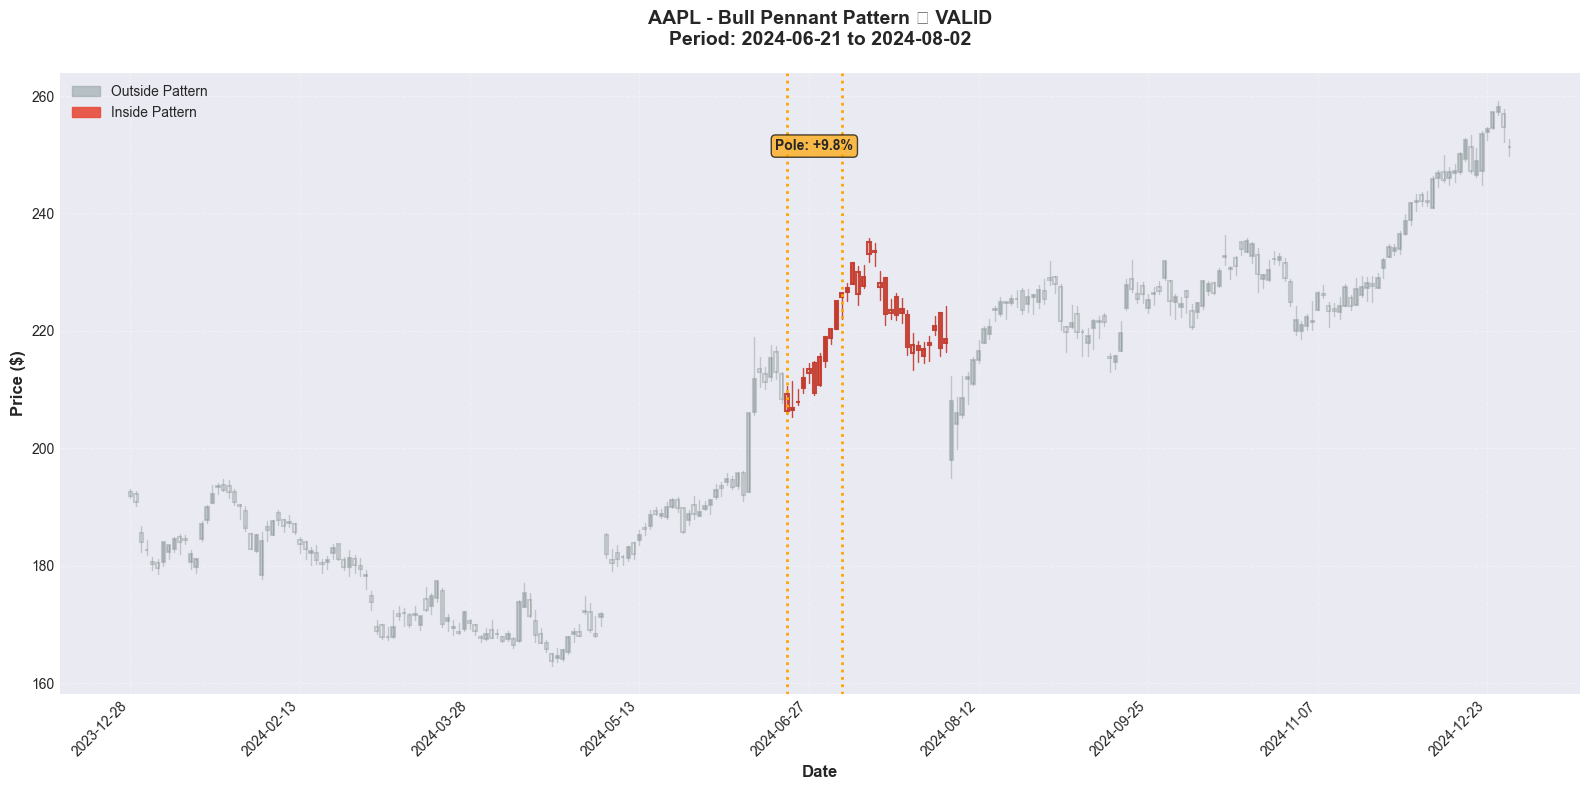

  Example 2: N/A


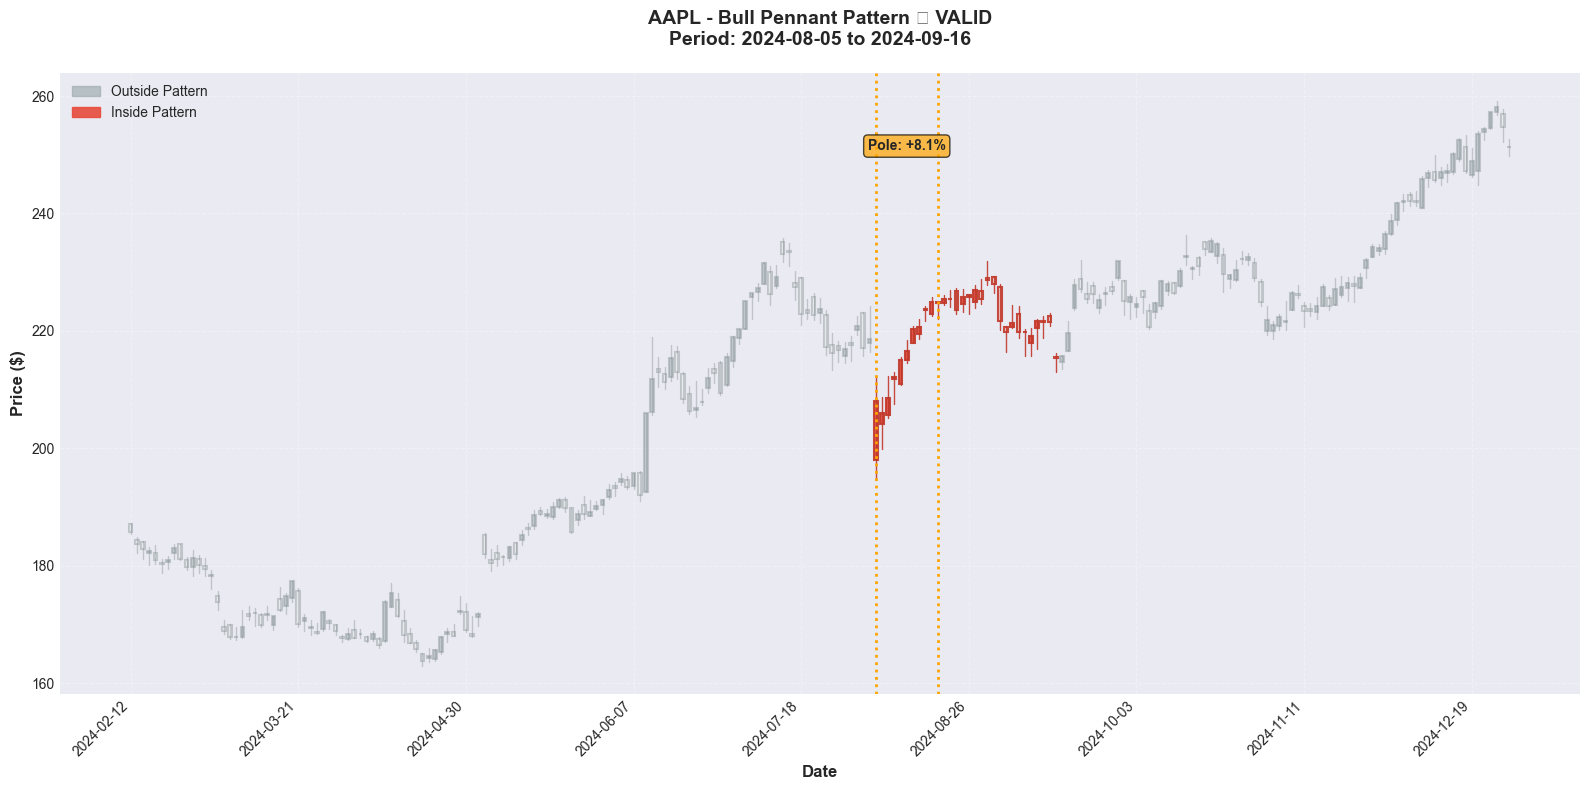


Double Bottom: showing 1 example(s)
  Example 1: 2024-03-07T00:00:00.000000000


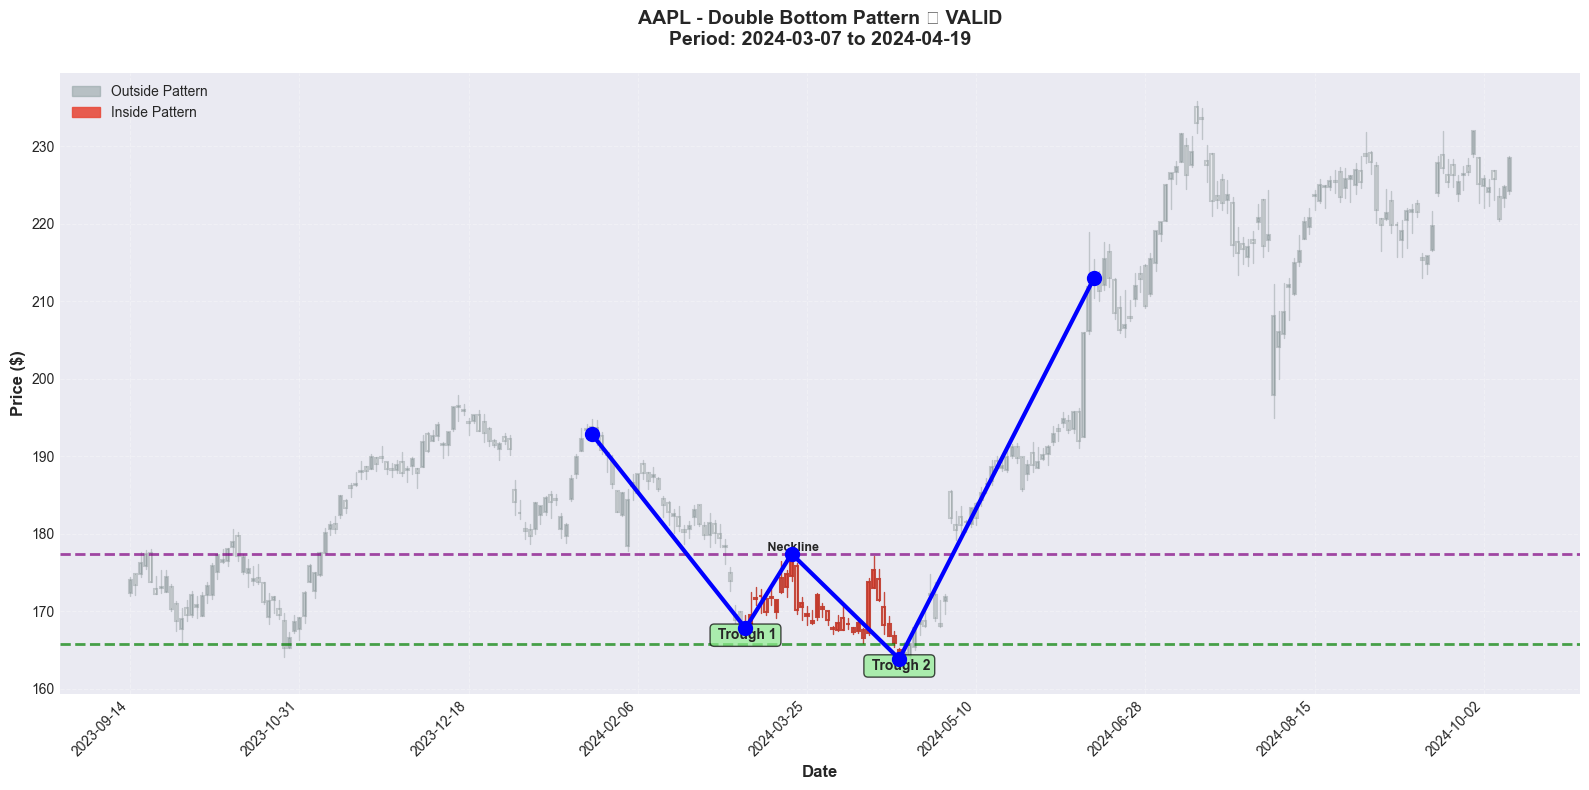


Double Top: showing 2 example(s)
  Example 1: 2022-02-09T00:00:00.000000000


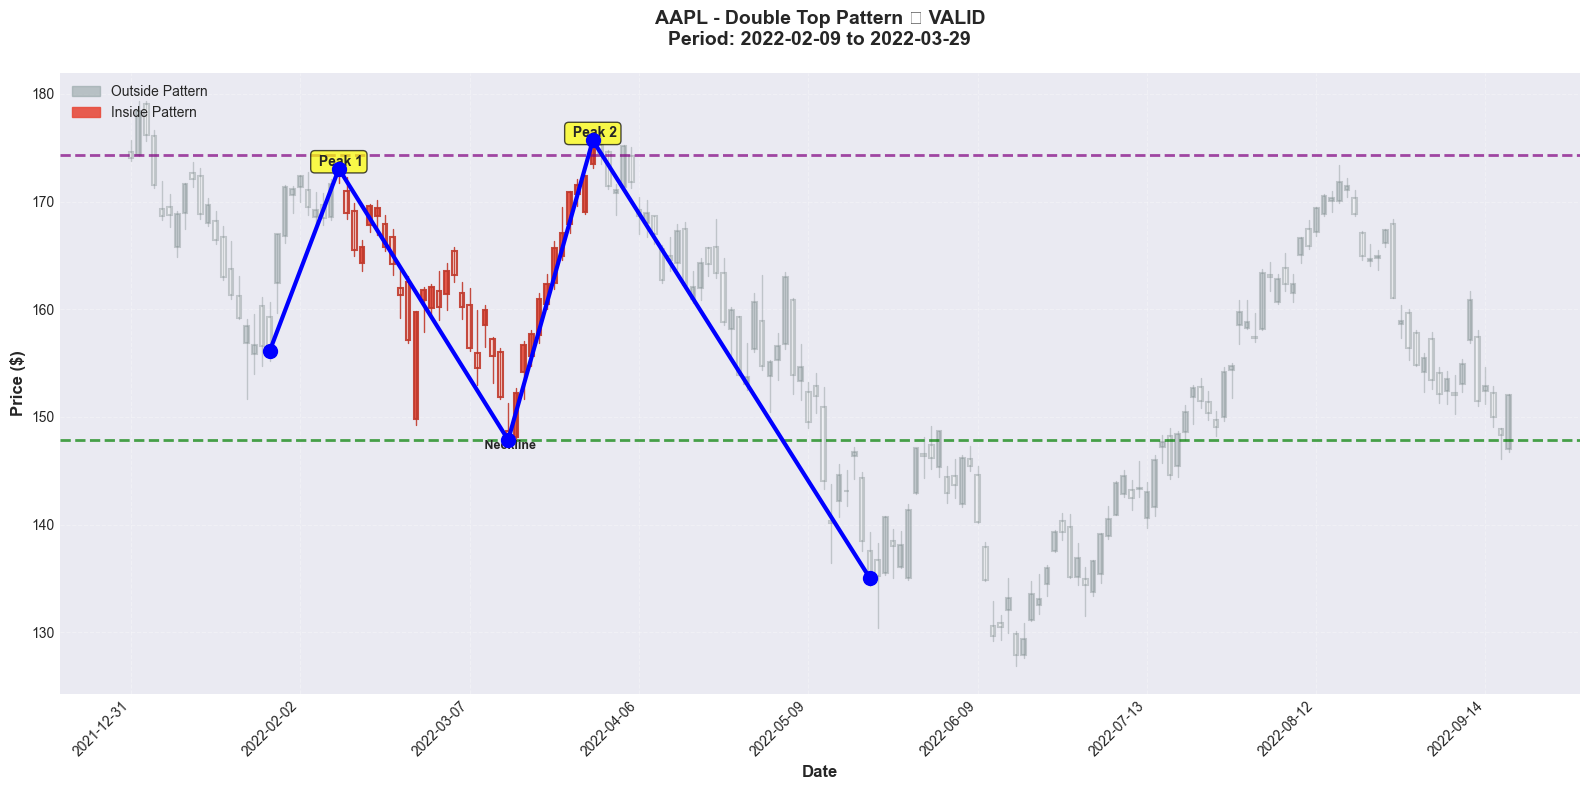

  Example 2: 2022-11-18T00:00:00.000000000


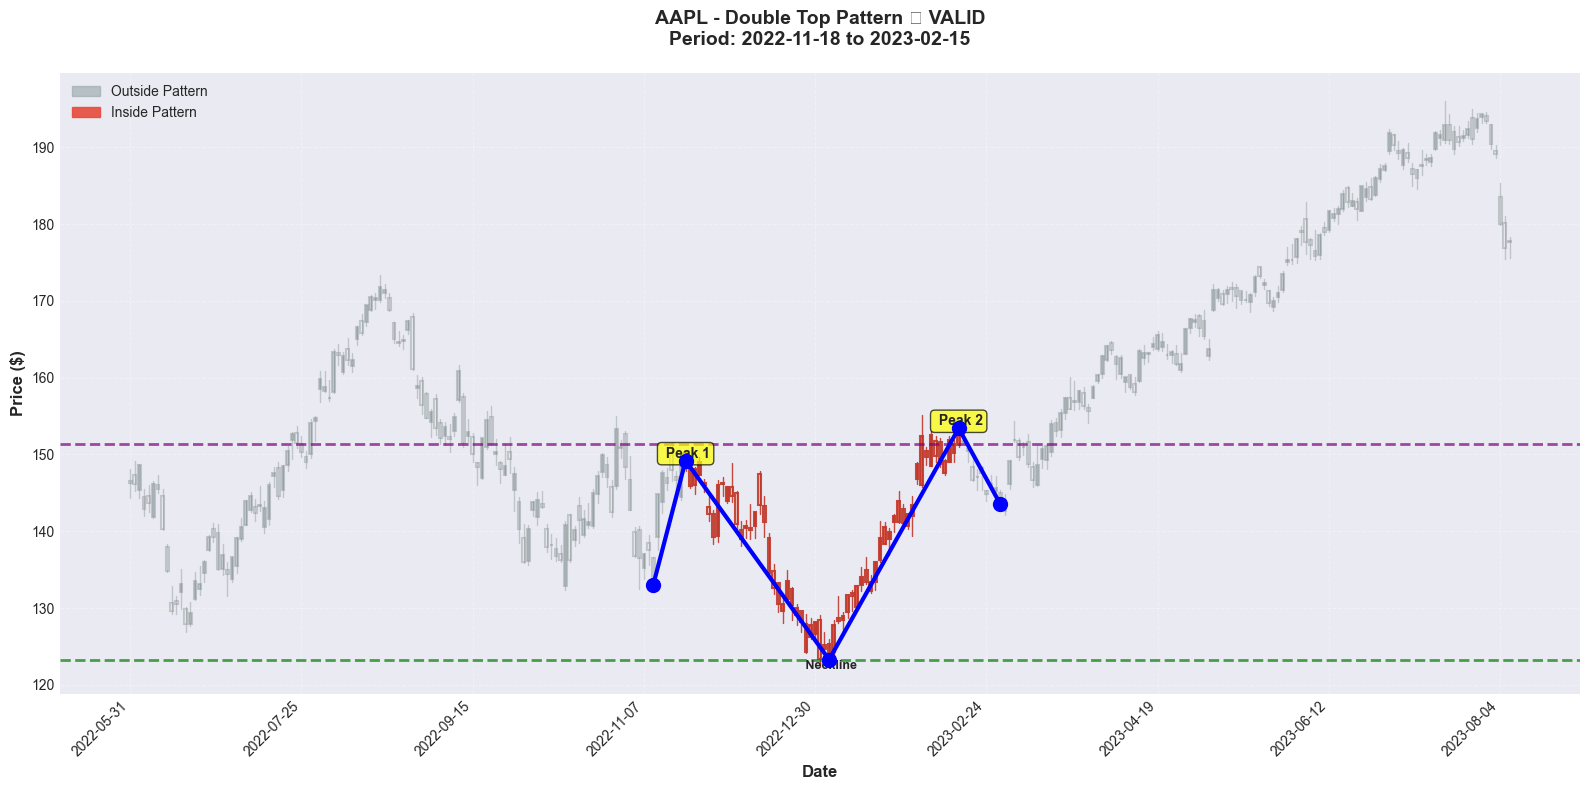


Symmetric Triangle: showing 1 example(s)
  Example 1: 2024-06-21T00:00:00.000000000


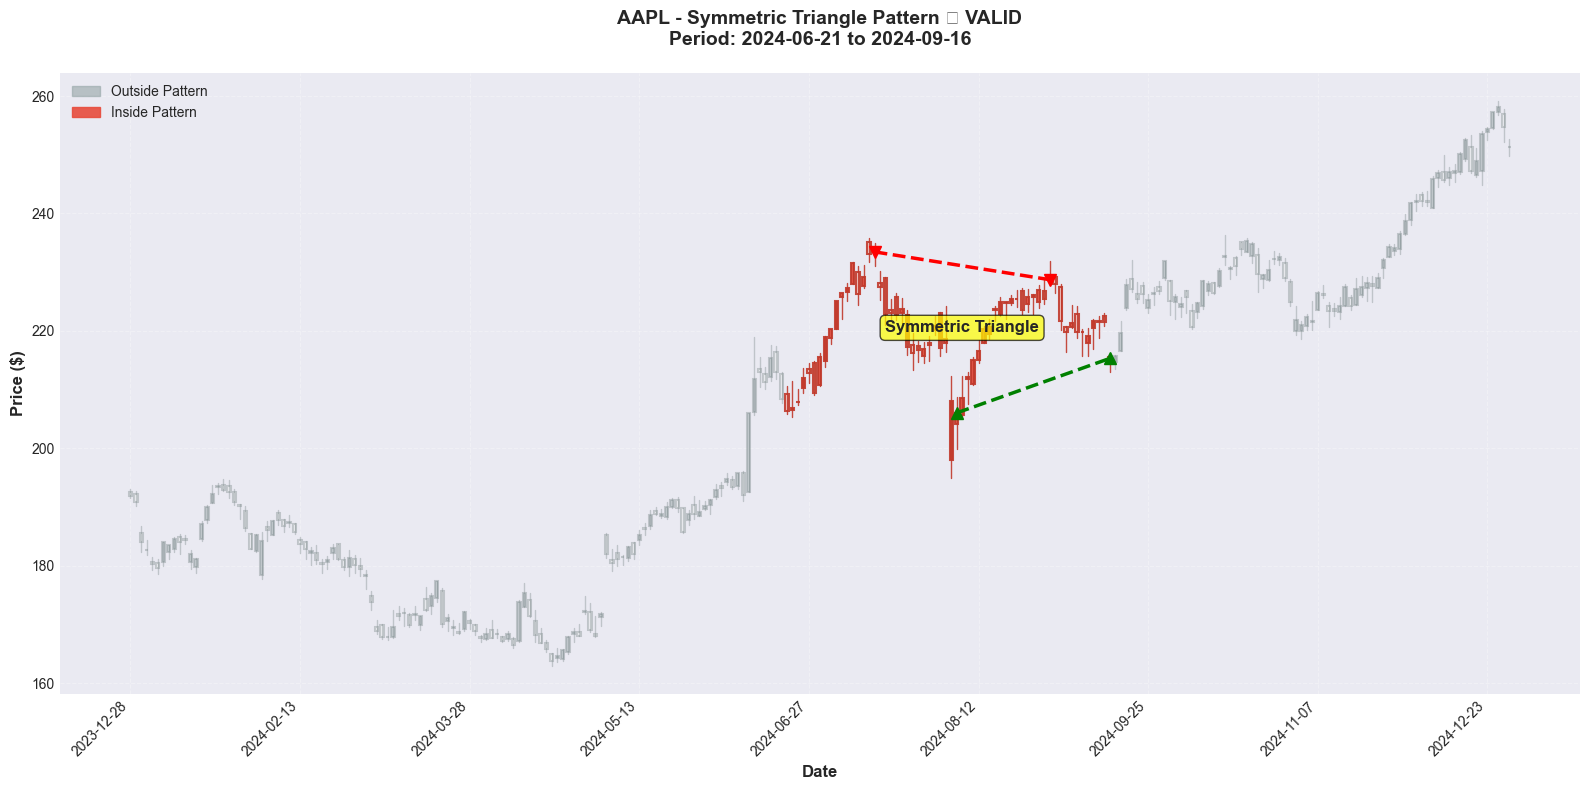

In [22]:
# Display sample patterns (at least 2 of each type)
pattern_types = {}
for p in valid_patterns:
    if p['type'] not in pattern_types:
        pattern_types[p['type']] = []
    pattern_types[p['type']].append(p)

for ptype in sorted(pattern_types.keys()):
    samples = pattern_types[ptype][:2]
    print(f"\n{ptype}: showing {len(samples)} example(s)")
    for i, pattern in enumerate(samples, 1):
        print(f"  Example {i}: {pattern['start_date'] if 'start_date' in pattern else pattern.get('cup_start_date', 'N/A')}")
        plot_candlestick_pattern(aapl_3yr, pattern, 'AAPL')


In [23]:
# Placeholder for statistical validation (Step 2)


In [24]:
# Save pattern data for later analysis
pattern_data_file = OUTPUT_DIR / 'aapl_patterns_3yr.json'
with open(pattern_data_file, 'w') as f:
    json.dump([p for p in all_aapl_patterns], f, indent=2, default=str)
print(f"Saved pattern data → {pattern_data_file}")


Saved pattern data → outputs\aapl_patterns_3yr.json


---

## Quick Reference: Using This Notebook

### Analyze a Single Stock
```python
result = analyze_stock_patterns('TICKER', save_plots=True)
```

### Analyze Custom Stock List
```python
my_stocks = ['AAPL', 'MSFT', 'GOOGL']
results = [analyze_stock_patterns(ticker) for ticker in my_stocks]
```

### Adjust Detection Parameters

For more sensitive detection (finds more patterns):
```python
hs_patterns = detect_head_and_shoulders(df, window=40, tolerance=0.08)
dt_patterns = detect_double_top_bottom(df, window=20, tolerance=0.05)
```

For stricter detection (fewer, higher quality patterns):
```python
hs_patterns = detect_head_and_shoulders(df, window=90, tolerance=0.03)
dt_patterns = detect_double_top_bottom(df, window=50, tolerance=0.02)
```

### Visualize a Specific Pattern
```python
df = load_stock_data('AAPL')
patterns = detect_head_and_shoulders(df)
if patterns:
    plot_pattern(df, patterns[0], 'AAPL')
```
